# Get Your OM PKI Credential

In this notebook we will be using the OM Authority agent to establish a connection with a mobile agent you can install on your phone. Once established, you will issue yourself a verifiable credential that you can use to prove you took this course. We will use this credential towards the end of the course. 



## 0. Install a Mobile Aries Agent of Your Choice

There are a number of apps available on the app store designed as *digital wallet's* to store verifiable credentials. The one's that work with the Hyperledger verifiable information platform all use code that implement's a set aries-rfcs, these specification's help ensure different implementations can interact.

You can pick the application you would prefer to install from any of the following:

* [Connect.Me](https://www.connect.me/)
* [Trinsic](https://trinsic.id/)
* [eSatus](https://esatus.com/?lang=en)
* [LISSI](https://lissi.id/)

Unfortunately to date none of the applications are open source, which in my view is leading to a fragmented experience for the individual. It is common to hear the phrase "Digital wallet's are the browsers of the future", or something along those lines. To which I often wonder why nobody has made it easy for me to write the equvalent of a webpage. 

Digital wallet's are an interesting space to keep an eye on. For the interested I recommend this report on [The Current and Future State of Digital Wallet's](https://wiki.hyperledger.org/download/attachments/24775535/The_Current_and_Future_State_of_Digital_Wallets_v1.0_FINAL.pdf?version=1&modificationDate=1574365535000&api=v2) from Darrell O'Donnell. Also available as a [webinar](https://ssimeetup.org/state-digital-identity-crypto-wallets-darrell-odonnell-webinar-22/).

The open source offering around mobile agent's and applications is gradually emerging, the most recent being the announcement of the [aries-bifold](https://github.com/Indicio-tech/aries-bifold) application and companion [aries-mobileagent-reactnative](https://github.com/Indicio-tech/aries-mobileagent-react-native) projects. If you would like to help us figure out how we could and should leverage and contribute too these offerings we would love to hear from you. 

For the moment we have to make do with what is available. So install one of the above applications and make sure you they are pointing to the **Sovrin StagingNet**. Different applications have different ways of changing the network the agent uses, usually in settings, although Connect.Me requires you select the network as part of the installation process.


## 1. Initialise a controller for Issuer

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://om-authority-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners for Webhook Topics

Listeners are a key aspect of the design of SSI Applications that use the ACA-Py code base. They specify how your application reacts to messages your agent instance recieves from others. 

Notice we are registering two different handlers, one for the `issue_credential` topic and the other for the `connections` topic. As discussed topic's generally relate to a protocol such as the issue-credential protocol that is defined [here](https://github.com/hyperledger/aries-rfcs/tree/master/features/0036-issue-credential).

In this example we are just parsing and printing information from the webhook payload. In future notebooks you will see how this can be used for more complex scenarios.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credential Webhook Payload")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    print("Handle Connection Webhook Payload")
    global STATE
    connection_id = payload["connection_id"]
    print("Connection ID", connection_id)

    STATE = payload['state']
    print("State", STATE)
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Establish a DIDComm connection with your Mobile Agent

Before you can issue yourself a credential using the OM Authority agent, you must establish a DIDComm connection by first exchanging DIDs. You can view the rfc for this protocol here.

You will first request the OM Authority agent to generate an invitation object containing a DID and assocaited public key. Then this information will need to be communicated **out of band**, the common approach to represent it as a QR Code that you will scan with your mobile SSI App. 

### 3a. Create an Invitation

The following cell creates the invitation object. This includes:
* `connection_id` - The primary key used to communicate to your agent which connection (and hence agent) you wish to send messages to
* `invitation` - A json object representing the invitation that needs to be communicated out of band. This includes the `recipientKeys` used to generate the DID and encrypt communication and a `seviceEndpoint` the location for the mobile agent to send messages too.
* `invitation_url` - This is the invitation object represented as a base64 string converted into a url. We use this to produce a QR Code.

Also notice the Connection webhook message output. This is from a webhook received by the AriesAgentController and handled by the function we defined in step 2. above.

In [12]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite["invitation"])
print("Invite Url")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'accept': 'auto', 'state': 'invitation', 'invitation_key': 'AMKtPnbqv6HhfJ3n5XhinRh9VNWUbz273aJwJdGXs6bw', 'connection_id': 'cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1', 'invitation_mode': 'once', 'routing_state': 'none', 'created_at': '2021-02-23 15:28:55.759515Z', 'initiator': 'self', 'updated_at': '2021-02-23 15:28:55.759515Z'} cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1
Connection ID cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1
Invitation
{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '2c36eeae-8501-40d4-99c0-c5abcbf240ad', 'recipientKeys': ['AMKtPnbqv6HhfJ3n5XhinRh9VNWUbz273aJwJdGXs6bw'], 'serviceEndpoint': 'https://cd0f4f80c823.ngrok.io', 'label': 'OM_AUTHORITY'}
Invite Url
https://cd0f4f80c823.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiMmMzNmVlYWUtODUwMS00MGQ0LTk5YzAtYzVhYmNiZjI0MGFkIiwgInJlY2lwaWVudEtleXMiOiBbIkFNS3RQbmJxdjZIaGZKM241WGhpblJoOVZOV1ViejI3M2FKd0pkR1

### 3b. Generate QR Code and Scan

You should use the mobile application you installed at the start of the notebook.

Once you scan the QR Code and accept the connection on your mobile application you should see a series of Connection webhook payload messages output from the cell. This is the om-authority-agent letting the application know that it has recieved a series of messages associated with the did-exchange protocol from another agent.

Notice that the connection_id contained in this payload is the same everytime? This shows us that all the messages arrived across the same connection. This should be the same as the connection_id from the output above.

Notice also that each new payload we handle has a different state? This is the protocol progressing through it's different stages until it completes and the connection is moved to active. You can view the state machine for this protocol [here](https://github.com/hyperledger/aries-rfcs/tree/master/features/0023-did-exchange#state-machine-tables).

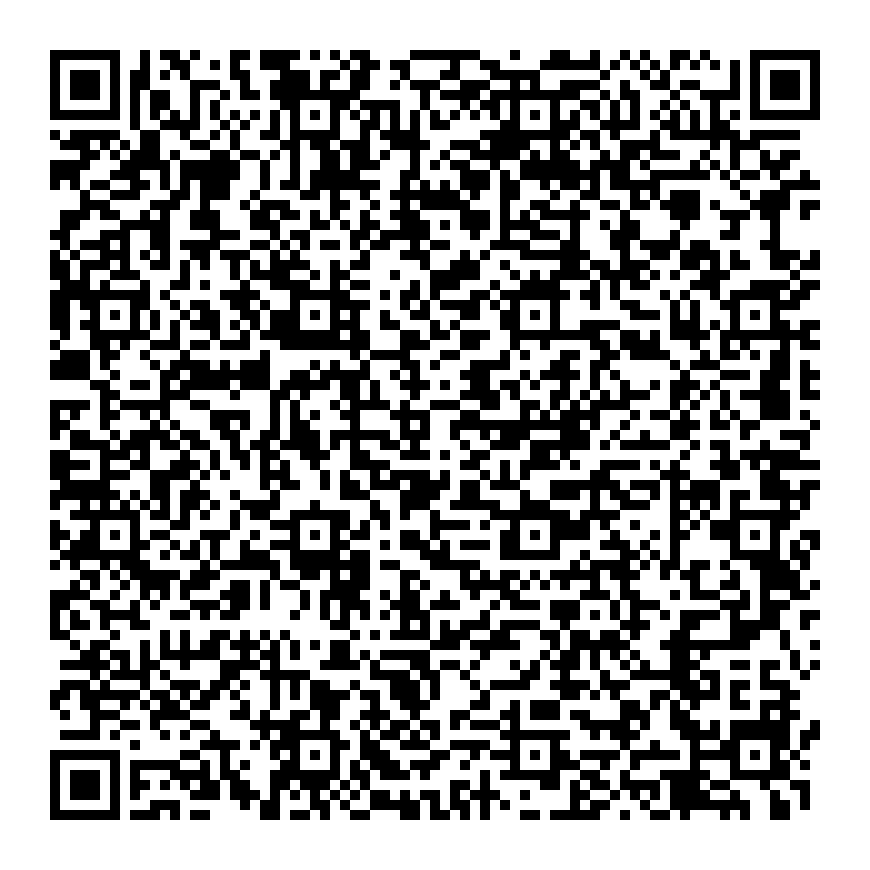

Connection message {'accept': 'auto', 'state': 'request', 'their_did': '8rQp2CRrc79reCfiZWNk61', 'invitation_key': 'AMKtPnbqv6HhfJ3n5XhinRh9VNWUbz273aJwJdGXs6bw', 'connection_id': 'cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1', 'their_label': 'some-random-name', 'invitation_mode': 'once', 'routing_state': 'none', 'created_at': '2021-02-23 15:28:55.759515Z', 'initiator': 'self', 'updated_at': '2021-02-23 15:36:46.932444Z'} cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1
Connection message {'accept': 'auto', 'state': 'response', 'their_did': '8rQp2CRrc79reCfiZWNk61', 'invitation_key': 'AMKtPnbqv6HhfJ3n5XhinRh9VNWUbz273aJwJdGXs6bw', 'connection_id': 'cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1', 'their_label': 'some-random-name', 'invitation_mode': 'once', 'routing_state': 'none', 'created_at': '2021-02-23 15:28:55.759515Z', 'my_did': 'RYDAe8RYaztbuY1nBocvzV', 'initiator': 'self', 'updated_at': '2021-02-23 15:36:46.950242Z'} cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1
Connection message {'accept': 'auto', 'state': 'activ

In [13]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

### 3c. Check if established connection is in active state

Depending on the mobile application you chose to use the connection state may not have progress to active yet. You can usually fix this by sending a trust ping to this connection.

If the connection state is still not active then you may need to try another application, apologies.

In [14]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1 is active
ConnectionId: cd1a98d9-88d8-45fc-ab49-9aa28c87f6c1 is now active. Continue with notebook


## 4. Load the Schema and Credential Definition Identifiers

**You should have stored these in the variables below in part 3.**

We decided to add this cell to draw attention to the fact that to issue credential you need the schema_id and cred_def_id for the credential you wish to issue ... but you likely would not have just written those objects to the ledger. That should be done as part of the initial configuration for your application. Instead you would fetch these identifiers from some storage managed somewhere in your application.

In [3]:
%store -r pki_schema_id
%store -r pki_cred_def_id

if pki_schema_id and pki_cred_def_id:
    print("Successfully loaded identifiers required to issue OM PKI Course credentials")
    print("Schema :", pki_schema_id)
    print("Cred Def :", pki_cred_def_id)

Successfully loaded identifiers required to issue OM PKI Course credentials
Schema : Sgg1wREgfEwbEPCQn9xEuE:2:OpenMined PKI Course:0.0.1
Cred Def : HfpqnWtLjz9Js3iTeARU2B:3:CL:188817:default


## 5. Populate the Attribues for the Credential

Feel free to fill in your name however you like, this is your credential.

Note how information gets entered into a credential before it is offered, signed and accepted is a key process that should be thought through in relation to the context of the application. In many situations there will need to be high assurance that the information in a credential is reliable and accurate.

**Bad data in == Bad data out.**

In [10]:
import datetime
tme = datetime.datetime.now()

name=input("Please enter the name you would like in your OM PKI Course Credential: ")
credential_attributes = [
    {"name": "name", "value": name},
    {"name": "date", "value": tme.strftime("%x")},
]
print(credential_attributes)


Please enter the name you would like in your OM PKI Course Credential: Wip
[{'name': 'name', 'value': 'Wip'}, {'name': 'date', 'value': '02/23/21'}]


## 6. Send Credential

This should send a credential offer to your mobile application, once you accept the offer your mobile agent will blindly contribute a commitment to the agents master secret. The OM Authority will complete the signature on the credential and send it back to your mobile where you will store it.

Pay attention to the credential webhook messages that get output, these should track the protocol as it progresses through the different stages in the issue-credential flow. See the state diagram [here](https://github.com/hyperledger/aries-rfcs/blob/master/features/0036-issue-credential/credential-issuance.png).

There are other ways to issue a credential that require multiple api calls at each stage of the protocol.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [15]:
record = await agent_controller.issuer.send_credential(connection_id, pki_schema_id, pki_cred_def_id, credential_attributes, trace=False)


Handle Credentials
Credential exchange cd69f4ce-83e0-4a01-a34e-faeeaf71100e, role: issuer, state: offer_sent
Offering: [{'name': 'name', 'value': 'Wip'}, {'name': 'date', 'value': '02/23/21'}]
Handle Credentials
Credential exchange cd69f4ce-83e0-4a01-a34e-faeeaf71100e, role: issuer, state: request_received
Offering: [{'name': 'name', 'value': 'Wip'}, {'name': 'date', 'value': '02/23/21'}]
Handle Credentials
Credential exchange cd69f4ce-83e0-4a01-a34e-faeeaf71100e, role: issuer, state: credential_issued
Offering: [{'name': 'name', 'value': 'Wip'}, {'name': 'date', 'value': '02/23/21'}]


## 7. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [16]:
response = await agent_controller.terminate()
print(response)

None


# Continue to 5.

Congratulations! You should now have a a cryptographically verifiable set of attributes attesting to your attendance on this course. Pretty cool hey? 

Next we will move away from mobile agents for now, interacting with two different agents using notebooks as we apply these concepts in a more OpenMinedy context. You will learn how the OM Authority (or any trusted authority) can issue crentials to participants in a privacy-preserving machine learning flow which can then be used to establish a secure, mutually authenticated peer to peer communications channel.